# Deconvolving Lena

In [21]:
using OffsetArrays
using StaticArrays
using Images
using FileIO
using Printf

In [22]:
using JImages

## Basis

### Spatial Filter

A spatial filter consists on a *neighborhood* (tipically a small window, say 3x3 of 5x5 around the pixel) and a *predefined operation* which is performed on the image pixels encompassed by the neighborhood. Filtering creates a new pixel with coordinates equal to the coordinates of the center of the neighborhood and whose value is the filtering operation. A *filtered* image is generated as the center of the filter visits each pixel in the input image. 

<img src="SpatialFiltering.png">

### Spatial correlation and convolution

Correlation and convolution are closely related concept. *Correlation is the process of moving a filter mask over the image and computing the sum of products at each location*. The mechanics of convolution are the same, except that the filter is first rotated by 180°. For symmetric filters both operations are the same.

<img src="corrAndConv.png"> 

The figure shows both operations in the case of a 1D function *f* and filter *w*. 
- (a) shows the f and w
- (b) shwows the starting position for corr (left) or conv (right). Notice that there are parts of the function that do not overlap. The solution to this problem is to pad f with enough 0s on either side to allow each pixel in w to visit every pixel in f. If the filter is of size m, we need m - 1 0s on either side of f. 
- (c) shows a padded function.
- The process of sliding the filter over f is shown in d through g. The first value of correlation is the sum of products of f and w for the initial position shown in c (the sum of products is 0). This corresponds to a displacement x = 0. To obtain the second value of correlation, we shift w one pixel location to the right (a displacement of x = 1) and compute the sum of products. The result again is 0. In fact, the first nonzero result is when x = 3, in which case the 8 in w overlaps the 1 in f and the result of correlation is 8. 
- Proceeding in this manner, we obtain the full correlation result in Fig. (g). Note that it took 12 values of x (i.e., x = 0, 1, 2, ..., 11) to fully slide w past f so that each pixel in w visited every pixel in f.

- correlation is a function of displacement of the filter. IThe first value of correlation corresponds to zero displacement of the filter, the second corresponds to one unit displacement, and so on. 
- correlating a filter w with a function that contains all 0s and a single 1 yields a result that is a copy of w , but rotated by 180°. We call a function that contains a single 1 with the rest being 0s a discrete unit impulse. So we conclude that correlation of a function with a discrete unit impulse yields a rotated version of the function at the location of the impulse.

- Instead a fundamental property of convolution is that convolving a function with a unit impulse yields a copy of the function at the location of the impulse. 
- To perform convolution all we do is rotate one function by 180° and perform the same operations as in correlation. As it turns out, it makes no difference which of the two functions we rotate.

<img src="corrAndConv2D.png">  

Extension to images (2D) is shown in the figure: f(x,y) is a 5x5 function and w(x,y) is a 3x3 filter. 
- We start by padding each dimension with 3-1 = 2 zeros in each side. Thus the padded image is 9 x 9. For a filter of size m * n, we pad the image with a minimum of m-1 rows of 0s at the top and bottom and n-1 columns of 0s on the left and right. In (a) the filter is in the initial position.
- (b) shows the correlation result. The first element different from zero is 9. Then, as we slide the window we obtain a rotated copy of w. Finally we crop to the dimensions of f. 
- (c) shows how to make the convolution. We need to *flip* the filter, changing the order of files and columns (the equivalent of rotatin the filter by 180 degrees). 
- (d) shows that the result of the convoltuion is a copy of the initial filter, with the dimension, in (e) of the image f (after cropping). 

The *correlation* of a filter w(x, y) of size m * n with an image f(x, y), denoted as $w(x, y) \star f(x, y)$, is:
$$
w(x,y) \star f(x,y) = \sum_{s = -a}^{a} \sum_{t = -b}^{b} w(s,t) f(x + s, y + t) 
$$

While  the *convolution* of a filter w(x, y) of size m * n with an image f(x, y), denoted as $w(x, y) \ast f(x, y)$, is:
$$
w(x,y) \ast f(x,y) = \sum_{s = -a}^{a} \sum_{t = -b}^{b} w(s,t) f(x-s, y-t) 
$$

Flipping and shifting f (in convolution) instead of w is done for notational simplicity. The equations are evaluated for all values of the displacement variables x and y so that every element of w visits every pixel in f, which we assume has been padded appropriately.

### Example: Generating a gaussian filter (or kernel)

A Gaussian function of two variables, with mean $\mu=0$ and std $\sigma$ has the  form

$$
g(x,y) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{x^2 + y^2}{2\sigma^2}}
$$

To generate, say, a 3x3 filter we sample it about its center. Thus, $w_1 = h(-1, -1), w_2 = h(-1, 0), ..., w_9 = h(1, 1)$. 


## Functions

### Flip

- Rotates a matrix by 180 deg

In [23]:
function flip2d(x::Array{Float64,2})
    y = copy(x)
    for d in 1:2
        y = reverse(y, dims=d)
    end
    return y
end

flip2d (generic function with 1 method)

### Gaussian Kernel

In [24]:
G(x,y,σ=1.0) = exp(-(x^2 + y^2) / (2 * σ^2) ) # not normalised
G(x::Int,y::Int,σ::Float64=1.0) = exp(-(x^2 + y^2) / (2 * σ^2) )
G(x::Float64,y::Float64,σ::Float64=1.0) = exp(-(x^2 + y^2) / (2 * σ^2) )

G(I::CartesianIndex{2}, σ::Float64=1.0) = G(I.I..., σ)  # I.I... matches the tuple I.I to values (x,y)


G (generic function with 8 methods)

In [25]:
function gaussian_filter(σ)
    l = 4 * ceil(Int, σ) + 1 # for \sigma = 1 5 x 5 filter
    w = l÷2
    gauss = SMatrix{l,l}(map(i->G(i, σ), CartesianIndices((-w:w, -w:w)))) 
    gauss./sum(gauss)  #divide all elements of gauss by its sum to normalise
end

gaussian_filter (generic function with 1 method)

### Filter frame (neighboors)

To perform a convolution, we slide a frame of the size of the filter (we will assume it to be squared for simplicity, like `w` in the exapmple above) centered in each element of the matrix representing the function to be convoluted (`fxy`), then multiply the elements of the filter by the elements contained in the frame and sum the products, replacing the value in the center of the frame by the result of the operation.

Each element of `fxy` is labeled by a CartexianIndex (i,j). Thus, we can represent the frame surrounding this element by (i-w:i+w, j-w:j+w), where w is the integer divison of the filter size and 2. For a 3 x 3 filter, w = 1. Notice that the idea of the sliding frame is well defined for filters of odd dimensions. For filters of even dimensions one needs to pad the filter with extra zeros. 

In [26]:
@inline function filter_frame(I::CartesianIndex{2}, filter_size::Int) 
    # assume that the filter is squared
    w = filter_size÷2   
    ntuple(i->(I.I[i]-w): (I.I[i]+w), 2)  # for N=2 i runs (1,2)
end

filter_frame (generic function with 1 method)

Define the filter `w` as in the example above:

### Padding

Suppose we want to pad an image with a border. Remember that for a filter of size m * n, we need to pad the image with a minimum of m-1 rows of 0s at the top and bottom and n-1 columns of 0s on the left and right. In (a) the filter is in the initial position. Let's assume for convenience that the filter is squared (mxm). Thus, if the image has size (s,l) an we define border = m-1 = 2, we need to pad with s + border (left/right), and s + border (top/bottom), so (s + 2 * border) in each axis. 

Suppose, as in our examples above that the image has size 5x5 and the filter has size 3x3. Then, m=2 and the passed image will have a size 5 + 2 * 2 = 9 in each axis. 

In [27]:
function pad(data, border)
    padded_size  = map(s->s+2*border, size(data))  # in each axis 
    
    # the padded_range is relative to the main image. 
    # We want to extend it to the left/up (1-border) and to the right/down (s+border)
    padded_range = map(s->(1-border):(s+border), size(data))
    
    # the range to index the output image extends from 1:s in each direction
    range        = CartesianIndices(map(s->1:s, size(data))) 
    
    # zeros dimension sxs and offset array 
    odata        = OffsetArray(zeros(eltype(data), padded_size), padded_range...)
    
    odata[range] = data # fill the padded image with the original data
     
    return odata, collect(range)
end

pad (generic function with 1 method)

### Convolution 

The function is applied like this

`f_convolved .= convolve2D.(range,(padded_img,), (filter,))`

This means that each element of the blurred image (f_convolved .=) is computed passing an element of the range that was produced by the padding (CartesianIndices ranging from 1:5 in each axis), and the full padded_img and filter (thus the notation (padded_img,) an (filter,)). The algorithm goes like this:

1. Given an index of the original image (.eg, (3,3), whose value is 1), take its neighborhood, which extends 3 to the left and 3 to the right (thus 0:6, 0:6). In the case of the first index ((1,1) whose value i 0), we go -2:4, -2:4.
2. We then compute the view of this element  and its neighborhood, which corresponds to the frame (fr) that needs to be multiplied by the filter (w).
3. Next we multiply fr and w element by element
4. finally we sum

In [28]:
function convolve2D(I, padf, filter) 
    # I rather than range, we will apply this function index by index
    frame = filter_frame(I, size(filter, 1))
    d  = @inbounds SMatrix{size(filter)...}(view(padf, frame...))
    sum(d .* filter)  # returns the view corresponding to index I
end

convolve2D (generic function with 1 method)

## Application

### Gaussian Kernel

Gaussian Kernel from ImageFilter

In [29]:
@time kg1 = Kernel.gaussian(1)

  0.000015 seconds (6 allocations: 832 bytes)


5×5 OffsetArray(::Array{Float64,2}, -2:2, -2:2) with eltype Float64 with indices -2:2×-2:2:
 0.00296902  0.0133062  0.0219382  0.0133062  0.00296902
 0.0133062   0.0596343  0.0983203  0.0596343  0.0133062
 0.0219382   0.0983203  0.162103   0.0983203  0.0219382
 0.0133062   0.0596343  0.0983203  0.0596343  0.0133062
 0.00296902  0.0133062  0.0219382  0.0133062  0.00296902

And from `gaussian_filter`defined above

In [30]:
@time gf = gaussian_filter(1.)

  0.000023 seconds (27 allocations: 2.359 KiB)


5×5 SArray{Tuple{5,5},Float64,2,25} with indices SOneTo(5)×SOneTo(5):
 0.00296902  0.0133062  0.0219382  0.0133062  0.00296902
 0.0133062   0.0596343  0.0983203  0.0596343  0.0133062
 0.0219382   0.0983203  0.162103   0.0983203  0.0219382
 0.0133062   0.0596343  0.0983203  0.0596343  0.0133062
 0.00296902  0.0133062  0.0219382  0.0133062  0.00296902

Both functions yield identical results but the function from Kernel is faster

### Convolution

Define filter

In [286]:
w = collect(transpose(Float64.(reshape(1:9, 3, 3))))

3×3 Array{Float64,2}:
 1.0  2.0  3.0
 4.0  5.0  6.0
 7.0  8.0  9.0

Define "unit function"

In [32]:
fxy = zeros(eltype(0.), (5,5))
fxy[3,3] = 1;

In [33]:
fxy

5×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

Define padded function and ranges

In [34]:
fxyp, range = pad(fxy, size(w,1)-1);

In [35]:
fxyp

9×9 OffsetArray(::Array{Float64,2}, -1:7, -1:7) with eltype Float64 with indices -1:7×-1:7:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [36]:
range

5×5 Array{CartesianIndex{2},2}:
 CartesianIndex(1, 1)  CartesianIndex(1, 2)  …  CartesianIndex(1, 5)
 CartesianIndex(2, 1)  CartesianIndex(2, 2)     CartesianIndex(2, 5)
 CartesianIndex(3, 1)  CartesianIndex(3, 2)     CartesianIndex(3, 5)
 CartesianIndex(4, 1)  CartesianIndex(4, 2)     CartesianIndex(4, 5)
 CartesianIndex(5, 1)  CartesianIndex(5, 2)     CartesianIndex(5, 5)

Correlation

In [38]:
fcor = similar(fxy);
fcor .= convolve2D.(range, (fxyp,), (w,));

In [39]:
fcor

5×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  9.0  8.0  7.0  0.0
 0.0  6.0  5.0  4.0  0.0
 0.0  3.0  2.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0

Convolution

In [153]:
range

5×5 Array{CartesianIndex{2},2}:
 CartesianIndex(1, 1)  CartesianIndex(1, 2)  …  CartesianIndex(1, 5)
 CartesianIndex(2, 1)  CartesianIndex(2, 2)     CartesianIndex(2, 5)
 CartesianIndex(3, 1)  CartesianIndex(3, 2)     CartesianIndex(3, 5)
 CartesianIndex(4, 1)  CartesianIndex(4, 2)     CartesianIndex(4, 5)
 CartesianIndex(5, 1)  CartesianIndex(5, 2)     CartesianIndex(5, 5)

In [40]:
fcon = similar(fxy);
fcon .= convolve2D.(range, (fxyp,), (flip2d(w),));

In [41]:
fcon

5×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  1.0  2.0  3.0  0.0
 0.0  4.0  5.0  6.0  0.0
 0.0  7.0  8.0  9.0  0.0
 0.0  0.0  0.0  0.0  0.0

### Convolution using ImageFilter

In [288]:
@time ifcon = imfilter(fxy, reflect(centered(w)), Fill(0))

  1.458668 seconds (2.77 M allocations: 135.874 MiB, 2.40% gc time)


5×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  1.0  2.0  3.0  0.0
 0.0  4.0  5.0  6.0  0.0
 0.0  7.0  8.0  9.0  0.0
 0.0  0.0  0.0  0.0  0.0

#### Identical results!

### Timing

In [292]:
@time ifcon = imfilter(fxy, reflect(centered(w)), Fill(0))

  0.000038 seconds (25 allocations: 4.125 KiB)


5×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  1.0  2.0  3.0  0.0
 0.0  4.0  5.0  6.0  0.0
 0.0  7.0  8.0  9.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [293]:
@time fcon .= convolve2D.(range, (fxyp,), (flip2d(w),))

  0.000094 seconds (723 allocations: 44.953 KiB)


5×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  1.0  2.0  3.0  0.0
 0.0  4.0  5.0  6.0  0.0
 0.0  7.0  8.0  9.0  0.0
 0.0  0.0  0.0  0.0  0.0

## Reading Lena

In [237]:
datadir

"/Users/jj/JuliaProjects/JImages/data"

In [238]:
path = string(datadir, "/", "lena.h5")
println("path to Lena is $path")
lena = load_h5(path, "lena");

path to Lena is /Users/jj/JuliaProjects/JImages/data/lena.h5


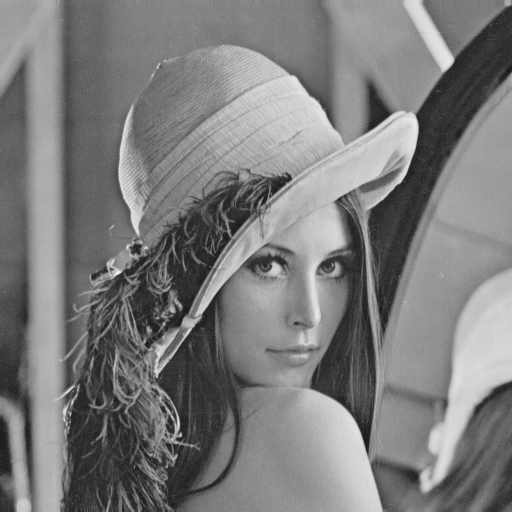

In [239]:
Gray.(lena)

### Convolving lena

With img filter

In [242]:
@time lena_g1 = imfilter(lena, reflect(centered(kg1)), Fill(0));

  0.002893 seconds (148 allocations: 4.175 MiB)


With convolve2D

In [243]:
lenap, range = pad(lena, size(gf,1)-1);

In [244]:
lena_c = similar(lena);

In [245]:
w = flip2d(collect(gf))

5×5 Array{Float64,2}:
 0.00296902  0.0133062  0.0219382  0.0133062  0.00296902
 0.0133062   0.0596343  0.0983203  0.0596343  0.0133062
 0.0219382   0.0983203  0.162103   0.0983203  0.0219382
 0.0133062   0.0596343  0.0983203  0.0596343  0.0133062
 0.00296902  0.0133062  0.0219382  0.0133062  0.00296902

In [248]:
@time lena_c .= convolve2D.(range, (lenap,), (w,));

  0.770174 seconds (7.08 M allocations: 520.000 MiB, 7.87% gc time)


In [249]:
lena_g1

512×512 Array{Float64,2}:
 0.31246    0.421111  0.444866  0.443682  …  0.451843  0.397397  0.27131
 0.421261   0.567746  0.599772  0.598175     0.609179  0.535774  0.365782
 0.445538   0.600464  0.634336  0.632647     0.644285  0.56665   0.386861
 0.445768   0.600462  0.633795  0.631916     0.635071  0.556742  0.379225
 0.446303   0.600195  0.631689  0.629097     0.584801  0.505096  0.340806
 0.445554   0.59846   0.628296  0.625085  …  0.471604  0.396277  0.26383
 0.441374   0.593624  0.624591  0.622501     0.340217  0.283241  0.190467
 0.435345   0.586502  0.619534  0.619809     0.246178  0.212836  0.149299
 0.430061   0.580736  0.616137  0.617964     0.201198  0.183492  0.13383
 0.427989   0.578537  0.615031  0.616976     0.187661  0.176202  0.130535
 0.428643   0.578968  0.615153  0.617203  …  0.185379  0.17661   0.132206
 0.430351   0.580509  0.615488  0.617155     0.184693  0.176699  0.132943
 0.432148   0.582388  0.615933  0.616313     0.186469  0.178672  0.134248
 ⋮             

In [250]:
lena_c

512×512 Array{Float64,2}:
 0.31246    0.421111  0.444866  0.443682  …  0.451843  0.397397  0.27131
 0.421261   0.567746  0.599772  0.598175     0.609179  0.535774  0.365782
 0.445538   0.600464  0.634336  0.632647     0.644285  0.56665   0.386861
 0.445768   0.600462  0.633795  0.631916     0.635071  0.556742  0.379225
 0.446303   0.600195  0.631689  0.629097     0.584801  0.505096  0.340806
 0.445554   0.59846   0.628296  0.625085  …  0.471604  0.396277  0.26383
 0.441374   0.593624  0.624591  0.622501     0.340217  0.283241  0.190467
 0.435345   0.586502  0.619534  0.619809     0.246178  0.212836  0.149299
 0.430061   0.580736  0.616137  0.617964     0.201198  0.183492  0.13383
 0.427989   0.578537  0.615031  0.616976     0.187661  0.176202  0.130535
 0.428643   0.578968  0.615153  0.617203  …  0.185379  0.17661   0.132206
 0.430351   0.580509  0.615488  0.617155     0.184693  0.176699  0.132943
 0.432148   0.582388  0.615933  0.616313     0.186469  0.178672  0.134248
 ⋮             

In [251]:
isapprox(lena_g1, lena_c)

true

#### Same result but much slower! The reason is that imfilter uses fft for large images.

## An alternative algorithm, using only regular arrays

Function pad2 assumes that the filter is squared. 
 - If m = size(filter,1) = size(filter,2), then, pad = m-1 and size of padded image is 2*m in each axis

In [218]:
function pad2(data, pad)
    padded_size  = map(s->s+2*pad, size(data))  # in each axis 
    padded_range = map(s->1:s, padded_size)   
    odata        = zeros(eltype(data), padded_size)
    m, n = size(data)
    i0 = pad + 1
    il = pad + m
    jl = pad + n
    odata[i0:il, i0:jl] = data[1:m, 1:n]
    return odata
end

pad2 (generic function with 1 method)

In [219]:
fxyp = pad2(fxy, size(w,1)-1)

9×9 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

Function `get_frames` computes the succesive frames as the filter is sliding over the function.
- Notice, for fxyp (9x9) and w = (3x3) we get (7x7) frames. This corresponds to (9 - border, 9 -border) where border = size_filter -1

In [283]:
function get_frames(A, filter_size)
    border = filter_size -1 
    ci     = CartesianIndices(A)
    m,n    = size(A)
    mf     = m - border
    nf     = m - border
    frm    = [ci[i:i+border, j:j+border] for i in 1:mf for j in 1:nf]
    reshape(frm, mf, nf)
end
    

get_frames (generic function with 1 method)

In [287]:
size(w,1)

3

In [288]:
I = get_frames(f2xyp, size(w,1))

7×7 Array{Array{CartesianIndex{2},2},2}:
 [CartesianIndex(1, 1) CartesianIndex(1, 2) CartesianIndex(1, 3); CartesianIndex(2, 1) CartesianIndex(2, 2) CartesianIndex(2, 3); CartesianIndex(3, 1) CartesianIndex(3, 2) CartesianIndex(3, 3)]  …  [CartesianIndex(7, 1) CartesianIndex(7, 2) CartesianIndex(7, 3); CartesianIndex(8, 1) CartesianIndex(8, 2) CartesianIndex(8, 3); CartesianIndex(9, 1) CartesianIndex(9, 2) CartesianIndex(9, 3)]
 [CartesianIndex(1, 2) CartesianIndex(1, 3) CartesianIndex(1, 4); CartesianIndex(2, 2) CartesianIndex(2, 3) CartesianIndex(2, 4); CartesianIndex(3, 2) CartesianIndex(3, 3) CartesianIndex(3, 4)]     [CartesianIndex(7, 2) CartesianIndex(7, 3) CartesianIndex(7, 4); CartesianIndex(8, 2) CartesianIndex(8, 3) CartesianIndex(8, 4); CartesianIndex(9, 2) CartesianIndex(9, 3) CartesianIndex(9, 4)]
 [CartesianIndex(1, 3) CartesianIndex(1, 4) CartesianIndex(1, 5); CartesianIndex(2, 3) CartesianIndex(2, 4) CartesianIndex(2, 5); CartesianIndex(3, 3) CartesianIndex(3, 4) Carte

Function `convolve2G` performs the actual convolution

In [298]:
function convolve2G(ci, padf, filter) 
    frame = ntuple(i->ci[1].I[i]:ci[end].I[i], 2)
    #println("frame = ", frame)
    d  = view(padf, frame...)
    #println("d = ", d)
    s = sum(d .* filter)  # returns the view corresponding to index I
    #println("s =", s)
    return s
end

convolve2G (generic function with 1 method)

### CPU

In [225]:
fxy

5×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [226]:
w

3×3 Array{Float64,2}:
 1.0  2.0  3.0
 4.0  5.0  6.0
 7.0  8.0  9.0

In [227]:
border = size(w,1) -1

2

In [228]:
hb = border÷2

1

In [229]:
sm, sn = size(fxy)

(5, 5)

In [230]:
fxyp = pad2(fxy, border)

9×9 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [231]:
fconvpt = zeros(size(I))

7×7 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [232]:
fconvpt .= convolve2G.(I, (fxyp,), (flip2d(w),))

7×7 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  4.0  7.0  0.0  0.0
 0.0  0.0  2.0  5.0  8.0  0.0  0.0
 0.0  0.0  3.0  6.0  9.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [233]:
fconv = collect(transpose(fconvpt[1+hb:sm+hb, 1+hb:sn+hb]))

5×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  1.0  2.0  3.0  0.0
 0.0  4.0  5.0  6.0  0.0
 0.0  7.0  8.0  9.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [235]:
@time fconvpt .= convolve2G.(I, (fxyp,), (flip2d(w),))

  0.000037 seconds (97 allocations: 9.203 KiB)


7×7 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  4.0  7.0  0.0  0.0
 0.0  0.0  2.0  5.0  8.0  0.0  0.0
 0.0  0.0  3.0  6.0  9.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0

### Apply to LENA

In [252]:
lenap2 = pad2(lena, size(gf,1)-1)

520×520 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0       0.0       …  0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.635294  0.635294     0.501961  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.635294  0.635294  …  0.501961  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.635294  0.635294     0.501961  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.635294  0.635294     0.501961  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.635294  0.635294     0.501961  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.643137  0.643137     0.301961  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.627451  0.627451  …  0.227451  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.623529  0.623529     0.184314  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.607843  0.607843     0.192157  0.0  0.0  0.0  0.0
 ⋮                       

In [254]:
isapprox(collect(lenap), lenap2)

true

In [289]:
wf = flip2d(collect(gf))

5×5 Array{Float64,2}:
 0.00296902  0.0133062  0.0219382  0.0133062  0.00296902
 0.0133062   0.0596343  0.0983203  0.0596343  0.0133062
 0.0219382   0.0983203  0.162103   0.0983203  0.0219382
 0.0133062   0.0596343  0.0983203  0.0596343  0.0133062
 0.00296902  0.0133062  0.0219382  0.0133062  0.00296902

In [291]:
I = get_frames(lenap2, size(wf,1));

In [292]:
size(I)

(516, 516)

In [293]:
II = I[1]

5×5 Array{CartesianIndex{2},2}:
 CartesianIndex(1, 1)  CartesianIndex(1, 2)  …  CartesianIndex(1, 5)
 CartesianIndex(2, 1)  CartesianIndex(2, 2)     CartesianIndex(2, 5)
 CartesianIndex(3, 1)  CartesianIndex(3, 2)     CartesianIndex(3, 5)
 CartesianIndex(4, 1)  CartesianIndex(4, 2)     CartesianIndex(4, 5)
 CartesianIndex(5, 1)  CartesianIndex(5, 2)     CartesianIndex(5, 5)

In [295]:
fr = ntuple(i->II[1].I[i]:II[end].I[i], 2)

(1:5, 1:5)

In [303]:
border = size(wf,1) -1

4

In [304]:
hb = border÷2

2

In [305]:
sm, sn = size(lena)

(512, 512)

In [296]:
lconvpt = zeros(size(I));

In [299]:
lconvpt .= convolve2G.(I, (lenap2,), (wf,))

516×516 Array{Float64,2}:
 0.0018862   0.0103396   0.0242768  …  0.00658205  0.00280827  0.000512301
 0.0103396   0.0566782   0.133078      0.0360808   0.0153941   0.00280827
 0.0242768   0.133078    0.31246       0.0863178   0.0368467   0.00672177
 0.0327185   0.179353    0.421111      0.122408    0.0523236   0.00954516
 0.0345642   0.18947     0.444866      0.138688    0.0593668   0.01083
 0.0344721   0.188965    0.443682   …  0.142698    0.0610382   0.0111349
 0.0343149   0.188104    0.441658      0.14108     0.0602001   0.010982
 0.0342151   0.187556    0.440374      0.137106    0.0584237   0.010658
 0.0344242   0.188703    0.443065      0.137886    0.0587605   0.0107194
 0.0346692   0.190046    0.446218      0.143636    0.061199    0.0111643
 0.0347817   0.190663    0.447667   …  0.147222    0.0626563   0.0114301
 0.0346519   0.189951    0.445996      0.141617    0.0602463   0.0109905
 0.0344132   0.188643    0.442924      0.135636    0.0576684   0.0105202
 ⋮                      

In [301]:
@time lconvpt .= convolve2G.(I, (lenap2,), (wf,))

  0.073395 seconds (266.26 k allocations: 73.129 MiB)


516×516 Array{Float64,2}:
 0.0018862   0.0103396   0.0242768  …  0.00658205  0.00280827  0.000512301
 0.0103396   0.0566782   0.133078      0.0360808   0.0153941   0.00280827
 0.0242768   0.133078    0.31246       0.0863178   0.0368467   0.00672177
 0.0327185   0.179353    0.421111      0.122408    0.0523236   0.00954516
 0.0345642   0.18947     0.444866      0.138688    0.0593668   0.01083
 0.0344721   0.188965    0.443682   …  0.142698    0.0610382   0.0111349
 0.0343149   0.188104    0.441658      0.14108     0.0602001   0.010982
 0.0342151   0.187556    0.440374      0.137106    0.0584237   0.010658
 0.0344242   0.188703    0.443065      0.137886    0.0587605   0.0107194
 0.0346692   0.190046    0.446218      0.143636    0.061199    0.0111643
 0.0347817   0.190663    0.447667   …  0.147222    0.0626563   0.0114301
 0.0346519   0.189951    0.445996      0.141617    0.0602463   0.0109905
 0.0344132   0.188643    0.442924      0.135636    0.0576684   0.0105202
 ⋮                      

In [306]:
lconv = collect(transpose(lconvpt[1+hb:sm+hb, 1+hb:sn+hb]))

512×512 Array{Float64,2}:
 0.31246    0.421111  0.444866  0.443682  …  0.451843  0.397397  0.27131
 0.421261   0.567746  0.599772  0.598175     0.609179  0.535774  0.365782
 0.445538   0.600464  0.634336  0.632647     0.644285  0.56665   0.386861
 0.445768   0.600462  0.633795  0.631916     0.635071  0.556742  0.379225
 0.446303   0.600195  0.631689  0.629097     0.584801  0.505096  0.340806
 0.445554   0.59846   0.628296  0.625085  …  0.471604  0.396277  0.26383
 0.441374   0.593624  0.624591  0.622501     0.340217  0.283241  0.190467
 0.435345   0.586502  0.619534  0.619809     0.246178  0.212836  0.149299
 0.430061   0.580736  0.616137  0.617964     0.201198  0.183492  0.13383
 0.427989   0.578537  0.615031  0.616976     0.187661  0.176202  0.130535
 0.428643   0.578968  0.615153  0.617203  …  0.185379  0.17661   0.132206
 0.430351   0.580509  0.615488  0.617155     0.184693  0.176699  0.132943
 0.432148   0.582388  0.615933  0.616313     0.186469  0.178672  0.134248
 ⋮             

In [307]:
isapprox(lconv, lena_c)

true